# Fine-Tune a Model:
## Fine-tune a pre-trained CNN model for age detection on the UTK dataset. 

In [9]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence


### #  Data Generator Class

In [10]:

class DataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, image_size=(160,160), augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
        )

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_file_paths = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for file_path in batch_file_paths:
            img = cv2.imread(file_path)
            img = cv2.resize(img, self.image_size)
            images.append(img)
        images = np.array(images, dtype="float32") / 255.0
        if self.augment:
            images = next(self.datagen.flow(images, shuffle=False))
        return images, np.array(batch_labels)

# Step 2: Load File Paths and Labels
def load_file_paths_and_labels(dataset_path):
    file_paths = []
    labels = []
    for file in os.listdir(dataset_path):
        if file.endswith(".jpg"):
            try:
                age = int(file.split("_")[0])  # Extract age from filename
                file_paths.append(os.path.join(dataset_path, file))
                labels.append(age)
            except Exception as e:
                print(f"Error processing file {file}: {e}")
    return file_paths, labels

dataset_path = r"C:\Users\USER\Downloads\UTKFace"
file_paths, labels = load_file_paths_and_labels(dataset_path)



###  Group Ages into Categories

In [11]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = np.digitize(labels, bins) - 1
labels = to_categorical(labels, num_classes=len(bins))


In [12]:

train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)

batch_size =16
train_generator = DataGenerator(train_paths, train_labels, batch_size, augment=True)
test_generator = DataGenerator(test_paths, test_labels, batch_size)



### # Load Pre-Trained Model and Fine-Tune

In [13]:

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(labels.shape[1], activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some base layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### # Train the Model

In [14]:
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 2329s 2s/step - accuracy: 0.3731 - loss: 1.7535 - val_accuracy: 0.4675 - val_loss: 1.4583 - learning_rate: 1.0000e-04
Epoch 2/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 1818s 2s/step - accuracy: 0.4795 - loss: 1.3262 - val_accuracy: 0.5253 - val_loss: 1.2467 - learning_rate: 1.0000e-04
Epoch 3/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 1810s 2s/step - accuracy: 0.5211 - loss: 1.2369 - val_accuracy: 0.5468 - val_loss: 1.1910 - learning_rate: 1.0000e-04
Epoch 4/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 1330s 1s/step - accuracy: 0.5422 - loss: 1.1480 - val_accuracy: 0.5601 - val_loss: 1.0867 - learning_rate: 1.0000e-04
Epoch 5/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 1209s 1s/step - accuracy: 0.5578 - loss: 1.0962 - val_accuracy: 0.5392 - val_loss: 1.1609 - learning_rate: 1.0000e-04
Epoch 6/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 1257s 1s/step - accuracy: 0.5767 - loss: 1.0634 - val_accuracy: 0.5491 - val_loss: 1.1184 - learning_rate: 1.0000e-04
Epoch 7/10
1186/1186 ━━━━━━━━━━━━━━━━━━━

### # Evaluate the Model

In [16]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


297/297 ━━━━━━━━━━━━━━━━━━━━ 96s 259ms/step - accuracy: 0.5901 - loss: 1.0539
Test Loss: 1.0417, Test Accuracy: 0.5873


In [15]:
# Step 8: Prediction Function
def predict_age(image_path, model, bins):
    """
    Predicts the age of a person given an image.

    Parameters:
    - image_path: str, path to the image.
    - model: trained model.
    - bins: list of age bins used during training.

    Returns:
    - predicted_age: int, the predicted age category or exact age.
    """
    image_size = (160, 160)
    
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    img = cv2.resize(img, image_size)
    img = np.array(img, dtype="float32") / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict using the model
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    predicted_prob = predictions[0, predicted_class]

    # Interpolate the age for better granularity
    lower_bound = bins[predicted_class]
    upper_bound = bins[predicted_class + 1] if predicted_class + 1 < len(bins) else 100
    predicted_age = (lower_bound + upper_bound) / 2

    return predicted_class, predicted_prob, predicted_age

# Load the trained model
from tensorflow.keras.models import load_model

model_path = "age_detection_model_improved.h5"
model = load_model(model_path)

# Define the bins (should match training bins)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Test the prediction
test_image_path = r"C:\Users\USER\Downloads\UTKFace\22_1_0_20170110173815028.jpg.chip.jpg"  # Example image path
try:
    predicted_class, predicted_prob, predicted_age = predict_age(test_image_path, model, bins)
    print(f"Predicted Age Category: {predicted_class}")
    print(f"Predicted Probability: {predicted_prob:.4f}")
    print(f"Predicted Exact Age: {predicted_age:.1f}")
except Exception as e:
    print(f"Prediction failed: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
Predicted Age Category: 2
Predicted Probability: 0.7839
Predicted Exact Age: 25.0


### # Display Actual and Predicted Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Predicted Age Category: 2
Predicted Probability: 0.7839
Predicted Exact Age: 25.0


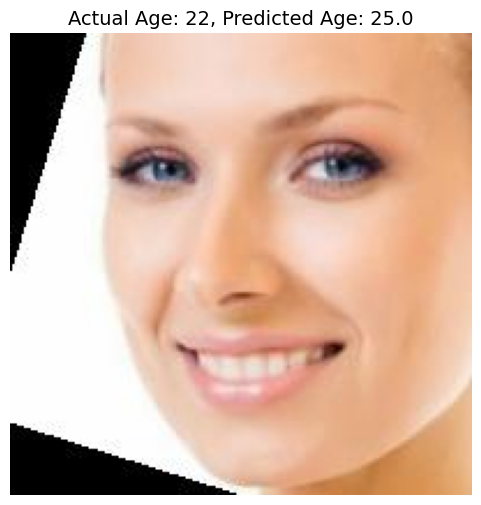

In [17]:
import matplotlib.pyplot as plt

def display_images(image_path, predicted_age, actual_age=None):
    """
    Displays the input image with actual and predicted ages.

    Parameters:
    - image_path: str, path to the input image.
    - predicted_age: float, the predicted exact age.
    - actual_age: int, the actual age (if available).
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Create a title with actual and predicted ages
    title = f"Predicted Age: {predicted_age:.1f}"
    if actual_age is not None:
        title = f"Actual Age: {actual_age}, " + title

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

# Test the prediction and visualization
try:
    # Extract the actual age from the filename
    actual_age = int(test_image_path.split("\\")[-1].split("_")[0])
    
    # Predict age
    predicted_class, predicted_prob, predicted_age = predict_age(test_image_path, model, bins)
    
    # Print predicted results
    print(f"Predicted Age Category: {predicted_class}")
    print(f"Predicted Probability: {predicted_prob:.4f}")
    print(f"Predicted Exact Age: {predicted_age:.1f}")
    
    # Display the image with actual and predicted ages
    display_images(test_image_path, predicted_age, actual_age=actual_age)

except Exception as e:
    print(f"Prediction or visualization failed: {e}")


In [18]:
# Save the Model
model.save("age_detection_model_improved.keras")

In [21]:
model.save("models/age_detection_model_improved.keras")


In [20]:
os.makedirs("models", exist_ok=True)
model.save("models/age_detection_model_improved.keras")


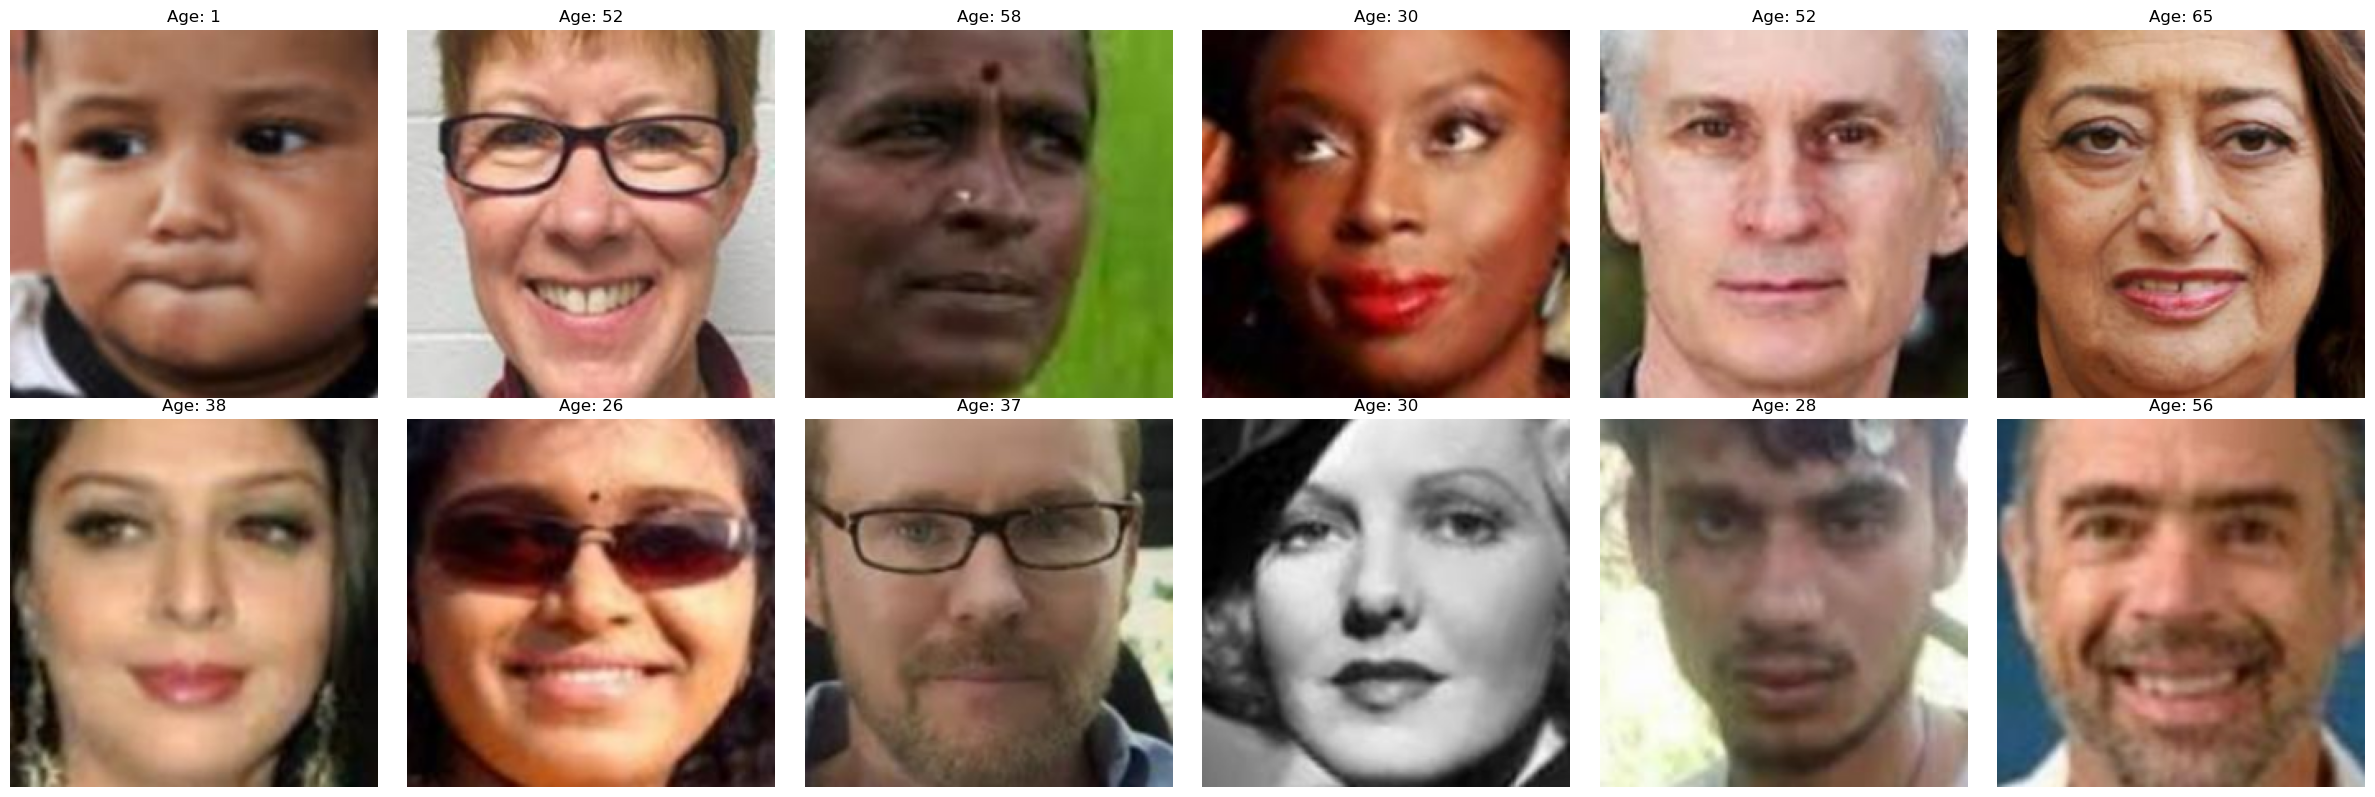

In [24]:
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_random_images(file_paths, labels, num_images=12, images_per_row=6):
    # Randomly sample file paths and labels
    sampled_indices = random.sample(range(len(file_paths)), num_images)
    sampled_file_paths = [file_paths[i] for i in sampled_indices]
    sampled_labels = [labels[i] for i in sampled_indices]

    # Calculate number of rows
    num_rows = int(np.ceil(num_images / images_per_row))
    plt.figure(figsize=(images_per_row * 4, num_rows * 4))  # Adjust figure size for the grid layout

    for i in range(num_images):
        img = cv2.imread(sampled_file_paths[i])
        img = cv2.resize(img, (224, 224))  # Resize image for consistent display
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization
        plt.subplot(num_rows, images_per_row, i + 1)  # Create grid layout
        plt.imshow(img)
        # Display the exact age as label
        age = int(sampled_file_paths[i].split("\\")[-1].split("_")[0])  # Extract age from filename
        plt.title(f"Age: {age}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize random images with exact age
visualize_random_images(file_paths, labels, num_images=12, images_per_row=6)


In [8]:
import importlib.metadata

required_packages = [
    "tensorflow",
    "numpy",
    "opencv-python",
    "scikit-learn",
    "matplotlib"
]

with open("requirements.txt", "w") as f:
    for package in required_packages:
        try:
            version = importlib.metadata.version(package)
            f.write(f"{package}=={version}\n")
        except importlib.metadata.PackageNotFoundError:
            print(f"Warning: {package} is not installed.")
            f.write(f"{package}\n")  # Write without version if not installed

print("requirements.txt file with exact versions has been created.")


requirements.txt file with exact versions has been created.
